In [25]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [26]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# Set number of classes

In [27]:
NUM_CLASSES = 3

# Set number of points and dimensions

In [28]:
TIME_STEPS = 16
DIMENSION = 2

# Dataset reading

In [29]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [30]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [32]:
use_lstm = True
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [33]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 16, 2)             0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 2)             0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1216      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                170       
                                                                 
 dense_3 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,419
Trainable params: 1,419
Non-traina

In [34]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [35]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [36]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
13/24 [===============>..............] - ETA: 0s - loss: 1.0967 - accuracy: 0.4495 
Epoch 1: saving model to model/point_history_classifier\point_history_classifier.hdf5
24/24 [==============================] - 2s 23ms/step - loss: 1.0954 - accuracy: 0.4608 - val_loss: 1.0921 - val_accuracy: 0.4054
Epoch 2/1000
13/24 [===============>..............] - ETA: 0s - loss: 1.0912 - accuracy: 0.4393
Epoch 2: saving model to model/point_history_classifier\point_history_classifier.hdf5
24/24 [==============================] - 0s 6ms/step - loss: 1.0903 - accuracy: 0.4401 - val_loss: 1.0849 - val_accuracy: 0.4605
Epoch 3/1000
13/24 [===============>..............] - ETA: 0s - loss: 1.0834 - accuracy: 0.4946
Epoch 3: saving model to model/point_history_classifier\point_history_classifier.hdf5
24/24 [==============================] - 0s 6ms/step - loss: 1.0796 - accuracy: 0.5289 - val_loss: 1.0665 - val_accuracy: 0.6306
Epoch 4/1000
13/24 [===============>..............] - ETA: 0s - l

In [37]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [38]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 321ms/step
[2.1090463e-07 9.9965739e-01 3.4234885e-04]
1


# Confusion matrix

32/32 [==============================] - 0s 1ms/step


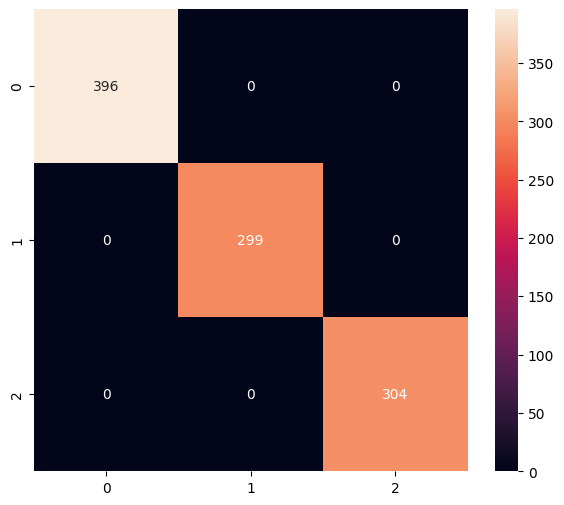

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       396
           1       1.00      1.00      1.00       299
           2       1.00      1.00      1.00       304

    accuracy                           1.00       999
   macro avg       1.00      1.00      1.00       999
weighted avg       1.00      1.00      1.00       999



In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [43]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [41]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [45]:
# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\nlmkatr\AppData\Local\Temp\tmppu6o381x\assets


INFO:tensorflow:Assets written to: C:\Users\nlmkatr\AppData\Local\Temp\tmppu6o381x\assets


ConverterError: c:\Users\nlmkatr\Anaconda3\envs\mediapipe\lib\site-packages\tensorflow\python\saved_model\save.py:1268:0: error: 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
c:\Users\nlmkatr\Anaconda3\envs\mediapipe\lib\site-packages\tensorflow\python\saved_model\save.py:1268:0: error: failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


# Inference test

In [46]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [47]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'input_1', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [48]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [49]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [50]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.8599032e-16 9.3985718e-01 1.6443740e-03 5.8498435e-02]
1
